In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import Yukawa_SINDy as ys
import pysindy as ps
from importlib import reload

In [88]:
# included to update Yukawa_SINDy.py version used in this notebook as changes are made
reload(ys)

<module 'Yukawa_SINDy' from '/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py'>

In [69]:
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

list of functions exported to 'Yukawa_SINDy.py'

- `generate_training_data`
- `plot_complexities`
- `scan_thresholds`
- `generate_libraries`

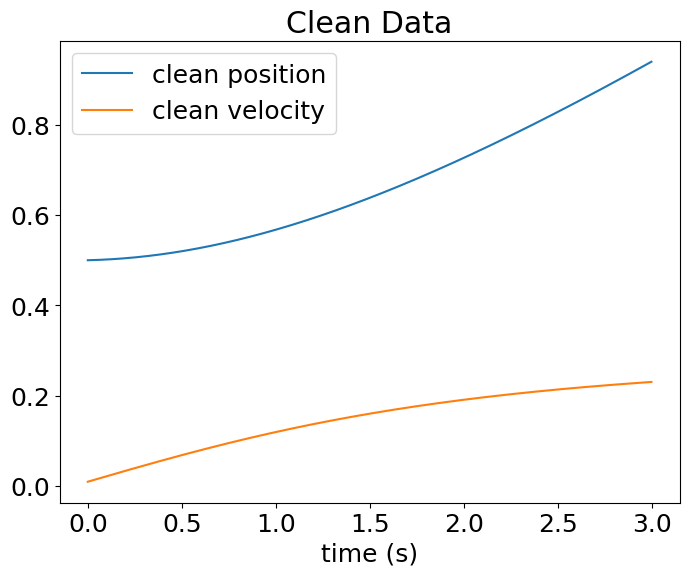

In [70]:
testsim = ys.Yukawa_simulation()
testsim.simulate(3, 0.001, 0.5,0.01,scaled=True)
testsim.plot()

In [71]:
positions = testsim.x[:,0]
avg_pos = np.average(np.abs(positions))
rms_pos = np.sqrt(np.sum(positions**2) / len(positions))
print("avg position:", avg_pos)
print("rms position:", rms_pos)
velocities = testsim.x[:,1]
avg_vel = np.average(np.abs(velocities))
rms_vel = np.sqrt(np.sum(velocities**2) / len(velocities))
print("avg velocity:", avg_vel)
print("rms velocity:", rms_vel)

avg position: 0.6649650524126033
rms position: 0.6782932483775096
avg velocity: 0.14642681665564844
rms velocity: 0.15992322367836945


In [72]:
# add noise and calculate signal-to-noise ratio (SNR) using avg positions
noise_level = 0.01
testsim.add_gaussian_noise(noise_level)

In [73]:
SNR_pos = avg_pos / noise_level
SNR_pos_dB = 10*np.log10(SNR_pos)
print("position SNR (dB):", SNR_pos_dB)
SNR_vel = avg_vel / noise_level
SNR_vel_dB = 10*np.log10(SNR_vel)
print("velocity SNR (dB):", SNR_vel_dB)

position SNR (dB): 18.22798821328387
velocity SNR (dB): 11.65620620841568


# Analysis of Yukawa 2-body data using Weak SINDy

In order to tie the simulation to real a dusty plasma system we normalize space and time according to the electron Debye length (`lambda_De` or $\lambda_{De}$, the relevant Yukawa screening length) and the plasma *dust* frequency in Hertz (`f_pd` or $f_{pd}$). These quantities are calculated below. The "scaling constant" comes from collecting all these values from the normalizations along with any constants in the equation of motion, so
$$
\begin{equation*}
    m_d\frac{d^2r}{dt^2}=\frac{q_d^2}{4\pi\varepsilon_0}
    \left[
        \frac{e^{-r/\lambda_{De}}}{\lambda_{De}r} + \frac{e^{-r/\lambda_{De}}}{r^2}
    \right],
\end{equation*}
$$
where $m_d$ is the mass of the dust, $r$ is the interparticle spacing, and $q_d$ is the dust charge, becomes
$$
\begin{equation*}
    \frac{d^2\hat{r}}{(dt^{*})^2}=A
    \left[
        \frac{e^{-\hat{r}}}{\hat{r}} + \frac{e^{-\hat{r}}}{\hat{r}^2}
    \right],
\end{equation*}
$$
where $\hat{r}=r/\lambda_{De}$, $t^*=f_{pd}t$, and $A=\frac{q_d^2}{4\pi\varepsilon_0 m_d f_{pd}^2 \lambda_{De}^3}$ is what we refer to as the "scaling constant."

In [105]:
# scaling constant
ep_0 = 8.85e-12 # epsilon naught
m_d = 3.03e-14  # dust mass in kg
mu = m_d / 2    # reduced mass
n_d = 1e11      # dust density in m^-3
n_e = 2.81e14   # electron density in m^-3
e = 1.60e-19    # fundamental charge in Coulombs
q_d = 1e4 * e   # dust charge
kT_e = 1.24e-18 # in Joules (converted from eV)

lambda_De = ( ( ep_0 * kT_e ) / ( n_e * e**2 ) )**(1/2)
omega_pd = np.sqrt( ( n_d * q_d**2 ) / ( ep_0 * m_d ) )
f_pd = omega_pd / (2 * np.pi)

A = q_d**2 / (4 * np.pi * ep_0 * mu * lambda_De**3 * f_pd**2)
print("scaling constant:", A)

scaling constant: 0.03334662321140632


In [106]:
lambda_De

0.0012351205151047975

In [107]:
px_dim = 14e-6

In [108]:
lambda_De / px_dim

88.22289393605696

We can interpret this scaling constant as proportional to a ratio of energies, particularly the electrostatic Coulomb potential energy and the electron thermal kinetic energy. We show this here:
$$
\begin{align*}
    A &= \frac{q_d^2}{4\pi\varepsilon_0\lambda_{De}} \frac{1}{m_d f_{pd}^2\lambda_{De}^2} \\
      &= \frac{q_d^2}{4\pi\varepsilon_0\lambda_{De}} \frac{1}{m_d} \frac{2\pi\varepsilon_0 m_d}{n_d q_d^2} \frac{n_e e^2}{\varepsilon_0 k_B T_e} \\
      &= \frac{q_d^2}{4\pi\varepsilon_0\lambda_{De}} 2\pi\frac{n_e}{n_d Z_d^2}\frac{1}{k_B T_e} \\
      &= 2\pi \frac{q_d^2}{4\pi\varepsilon_0\lambda_{De}} \frac{1}{k_B T_e}
\end{align*}
$$
where $k_B$ is the Boltzmann constant, $e$ is the fundamental charge, $Z_d=\frac{q_d}{e}$, and we used quasineutrality $n_e=Z_d n_d + n_i$ to cancel out the ratio of densities (probably not lol????) in  so
$$
\begin{equation*}
  A \propto \frac{\epsilon_{C,d}}{\epsilon_{th,e}}
\end{equation*}
$$
with $\epsilon_{C,d}=\frac{q_d^2}{4\pi\varepsilon_0\lambda_{De}}$ and $\epsilon_{th,e}=k_B T_e$

## `std_dev=0.01`

In [ ]:
# set var 'noise_level' for this section
noise_level = 0.01

The purpose of this notebook is to use a weak SINDy analysis on 2-body trajectories to see if the sparse recovery of simulation coefficients is improved. Results from the analysis of the same system using only one trajectory with strong-form SINDy (the original formulation) is shown in the notebook 'Yukawa2body.ipynb'.

Here, we will start by using one trajectory of the 2-body equations, as we did before, and then possibly extend to more trajectories.

In [ ]:
sim001 = ys.Yukawa_simulation()
sim001.simulate(5, dt=0.001, x0=0.5, v0=0.01, scaled=True)
sim001.add_gaussian_noise(noise_level=noise_level)
sim001.plot()

In [ ]:
thresholds = np.arange(0, A, 0.05*A)
thresholds, complexities = ys.scan_thresholds(sim001, thresholds, verbose=True)

In [ ]:
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

the model is fit at `threshold=0.35*A` to a very good approximation with the weak formulation. In this parameter range, the strong form does not really come close to the correct equation.

In [ ]:
thresholds = np.arange(0, 10*A, 0.5*A)
thresholds, complexities = ys.scan_thresholds(sim001, thresholds, verbose=True)
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

From this, we can see that strong form discovers nothing meaningful, even when the threshold is at $10A$.

In [ ]:
# code to be used for spot checking whatever threshold
threshold = 0.35*A
opt = ps.STLSQ(threshold=threshold)
weak_lib, strong_lib = ys.generate_libraries(sim001.t)
weak_model = ps.SINDy(feature_names=["x", "v"], feature_library=weak_lib, optimizer=opt)
weak_model.fit(sim001.x)
weak_model.print(precision=5)

## `std_dev=0.10`

In [74]:
noise_level=0.10

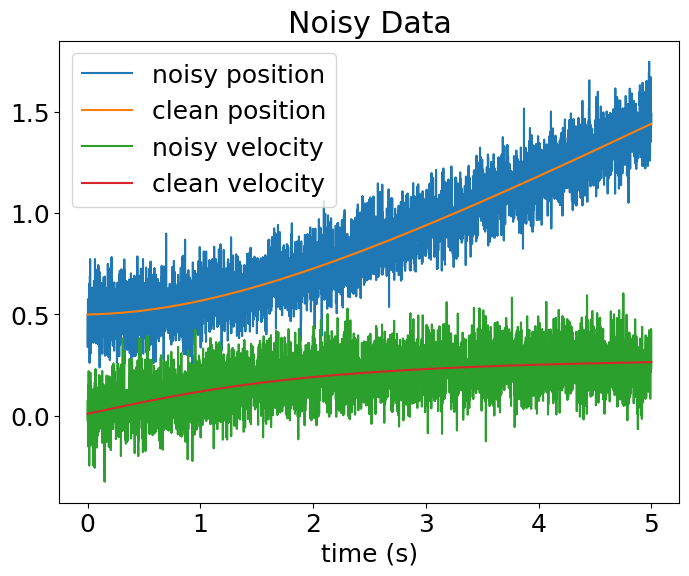

In [79]:
sim010 = ys.Yukawa_simulation()
sim010.simulate(5, dt=0.001,x0=0.5,v0=0.01,scaled=True)
sim010.add_gaussian_noise(noise_level=noise_level)
sim010.plot()

In [80]:
thresholds = np.arange(0, 2*A, 0.2*A)
print(thresholds)
print(thresholds/A)

[0.         0.00666932 0.01333865 0.02000797 0.0266773  0.03334662
 0.04001595 0.04668527 0.0533546  0.06002392]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


STLSQ threshold: 0.0 A

Weak model
(x)' = 0.16348 x + 0.03635 v + 0.04020 exp(-x) / x + 0.00165 exp(-v) / v + 0.03337 exp(-x) / x^2 + 0.01613 exp(-x) / x^3 + -0.02407 exp(-x) / x^4
(v)' = 0.00615 x + 0.00403 v + 0.02648 exp(-x) / x + -0.00365 exp(-v) / v + 0.03606 exp(-x) / x^2 + 0.03559 exp(-x) / x^3 + -0.01830 exp(-x) / x^4

Strong model
(x)' = -0.00001 exp(-v) / v^2
(v)' = -0.00001 exp(-v) / v^2


STLSQ threshold: 0.02 A

Weak model
(x)' = 0.22094 x + -1.23258 v + 3.31520 exp(-x) / x + -3.49705 exp(-x) / x^2 + 1.19002 exp(-x) / x^3 + -0.13125 exp(-x) / x^4
(v)' = -0.00929 x + 0.04599 v + -0.48549 exp(-x) / x + 0.94660 exp(-x) / x^2 + -0.47584 exp(-x) / x^3 + 0.06988 exp(-x) / x^4

Strong model
(x)' = 2.91636 x + -4.74488 v + -21.47825 exp(-x) / x + 0.00090 exp(-v) / v + 21.47399 exp(-x) / x^2 + -6.55781 exp(-x) / x^3 + 0.58579 exp(-x) / x^4
(v)' = 2.59415 x + -0.91571 v + -41.90548 exp(-x) / x + -0.00288 exp(-v) / v + 50.51359 exp(-x) / x^2 + -18.70763 exp(-x) / x^3 + 1.99398 exp(-x

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.1'}, xlabel='Threshold', ylabel='Number of terms'>)

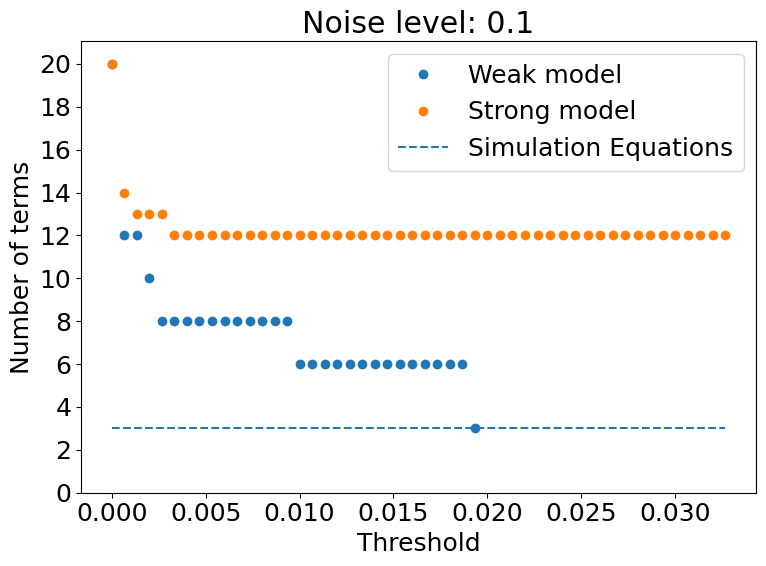

In [82]:
thresholds = np.arange(0, 1*A, 0.02*A)
thresholds, complexities = ys.scan_thresholds(sim010, thresholds, verbose=True)
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

With a single trajectory, WSINDy does not recover the correct equations of motion, but it does discover the leading terms along with the presence of extraneous terms. This improves with the multiple trajectories approach.

## Multiple trajectories

We can also generate many trajectories with different initial conditions and use that to train SINDy. This is what we were already doing for the three-body case, but we can see how much it improves the performance of SINDy here.

Note that we generate random initial conditions in the following way:

- *Initial positions*: taken from a normal distribution centered at 1 with std. dev. of 0.2
- *Initial velocities*: taken from a normal distribution centered at 0.01 with a std. dev. of 0.002, also with a random +/- sign.

This was done carefully so as to avoid there being zeros in the initial conditions, which create problems for the solver and for SINDy because of the presence of the rational terms.

### `noise_level=0.01`

In [83]:
# change 'noise_level' back to 0.01
noise_level = 0.01

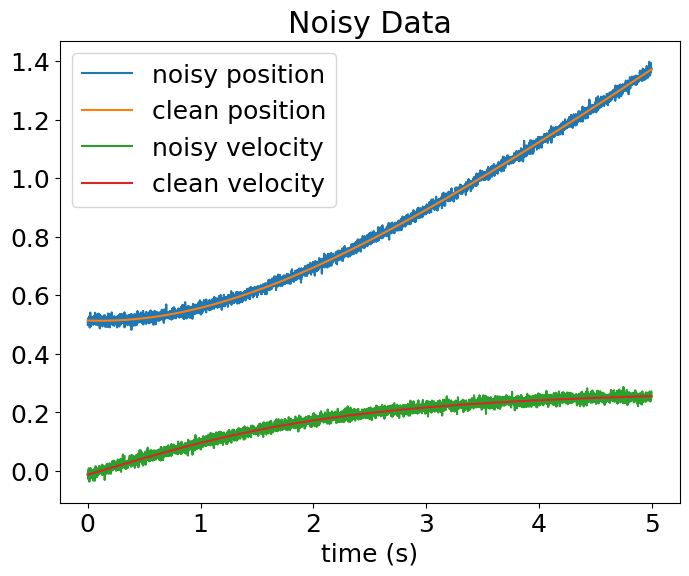

In [90]:
sims001 = ys.generate_training_data(noise_level=noise_level, scaled=True, mu_x0s=0.5)
sims001[73].plot()

In [93]:
sims001[100].is_scaled

True

In [94]:
thresholds = np.arange(0, 0.2*A, 0.01*A)
thresholds, complexities = ys.scan_thresholds(sims001, thresholds, verbose=True)

STLSQ threshold: 0.0 A

Weak model
(x)' = -0.00135 x + 1.00185 v + -0.00252 exp(-x) / x + 0.00128 exp(-x) / x^2 + -0.00039 exp(-x) / x^3 + 0.00004 exp(-x) / x^4
(v)' = -0.00107 x + 0.00206 v + 0.04105 exp(-x) / x + 0.02566 exp(-x) / x^2 + 0.00209 exp(-x) / x^3 + -0.00017 exp(-x) / x^4

Strong model
(x)' = 0.00001 exp(-x) / x + 0.00031 exp(-x) / x^2
(v)' = 0.00014 x + 0.00006 v + 0.00092 exp(-x) / x + 0.00001 exp(-v) / v + 0.03519 exp(-x) / x^2 + -0.00001 exp(-x) / x^3


STLSQ threshold: 0.001 A

Weak model
(x)' = -0.00138 x + 1.00190 v + -0.00169 exp(-x) / x + 0.00021 exp(-x) / x^2
(v)' = -0.00059 x + 0.00139 v + 0.03382 exp(-x) / x + 0.03293 exp(-x) / x^2

Strong model
(x)' = 0.00109 x + 0.99738 v + -0.01257 exp(-x) / x
(v)' = -0.04268 v + 0.09453 exp(-x) / x + 0.02057 exp(-x) / x^2


STLSQ threshold: 0.002 A

Weak model
(x)' = 0.99767 v + -0.00138 exp(-x) / x
(v)' = 0.03320 exp(-x) / x + 0.03312 exp(-x) / x^2

Strong model
(x)' = 0.00109 x + 0.99738 v + -0.01257 exp(-x) / x
(v)' = -0

So the "correct model" is discovered by the weak form when `threshold=0.04*A` with no small extraneous terms.

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

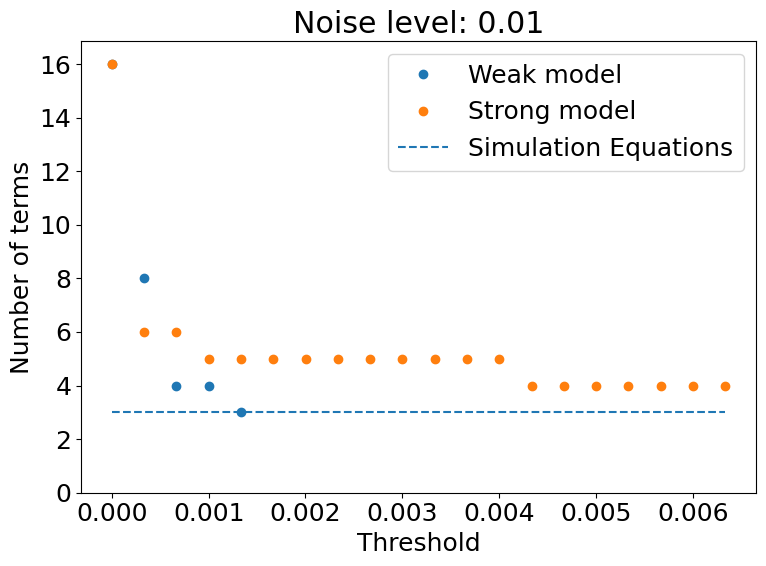

In [95]:
ys.plot_complexities(thresholds,complexities, noise_level)

### `noise_level=0.10`

In [96]:
noise_level = 0.10

In [101]:
sims010 = ys.generate_training_data(noise_level=noise_level, mu_x0s=0.5, scaled=True)

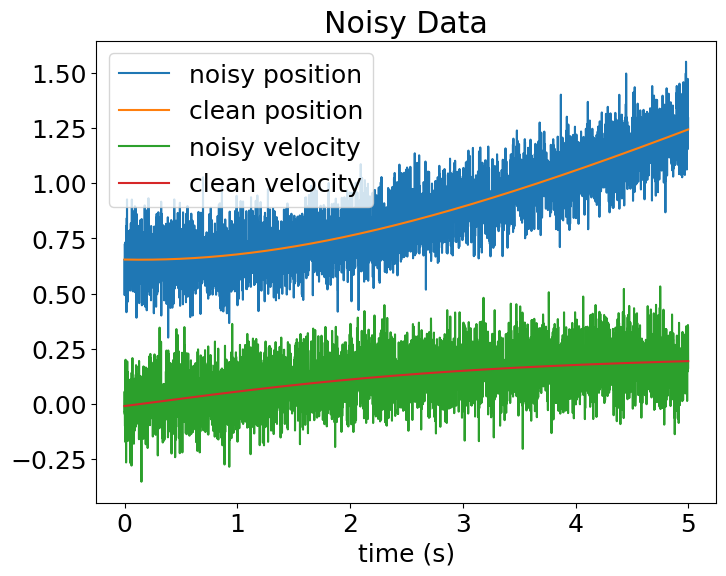

In [102]:
sims010[38].plot()

In [103]:
# thresholds = np.arange(0, 0.2, 0.01)
thresholds = np.concatenate((np.arange(0, 0.2*A, 0.01*A), np.arange(0.2*A, 1.0*A, 0.05*A), np.arange(1.0*A, 5.0*A, 0.5*A)))
libs = ys.generate_libraries(sims010[0].t)
x_train010 = [sim.x for sim in sims010]
t_train010 = sims010[0].t
thresholds, complexities = ys.scan_thresholds(sims010, thresholds, verbose=True)

STLSQ threshold: 0.0 A

Weak model
(x)' = -0.01465 x + 1.01774 v + -0.00987 exp(-x) / x
(v)' = -0.02131 x + 0.04929 v + 0.09770 exp(-x) / x + 0.00005 exp(-x) / x^2

Strong model
(x)' = -0.00001 exp(-v) / v + -0.00003 exp(-x) / x^2
(v)' = -0.00001 exp(-v) / v + -0.00003 exp(-x) / x^2


STLSQ threshold: 0.001 A

Weak model
(x)' = -0.01485 x + 1.01729 v + -0.00879 exp(-x) / x
(v)' = -0.02177 x + 0.05828 v + 0.09280 exp(-x) / x

Strong model
(x)' = 0.47908 x + -1.15598 v + 0.02530 exp(-x) / x
(v)' = 0.12903 x + -0.34891 v + -0.01010 exp(-x) / x


STLSQ threshold: 0.002 A

Weak model
(x)' = -0.01485 x + 1.01729 v + -0.00879 exp(-x) / x
(v)' = -0.02177 x + 0.05828 v + 0.09280 exp(-x) / x

Strong model
(x)' = 0.47908 x + -1.15598 v + 0.02530 exp(-x) / x
(v)' = 0.12903 x + -0.34891 v + -0.01010 exp(-x) / x


STLSQ threshold: 0.003 A

Weak model
(x)' = -0.01485 x + 1.01729 v + -0.00879 exp(-x) / x
(v)' = -0.02177 x + 0.05828 v + 0.09280 exp(-x) / x

Strong model
(x)' = 0.47908 x + -1.15598 v + 

/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.13338649284562526) and eliminated all coefficients
  warnings.warn(


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.1'}, xlabel='Threshold', ylabel='Number of terms'>)

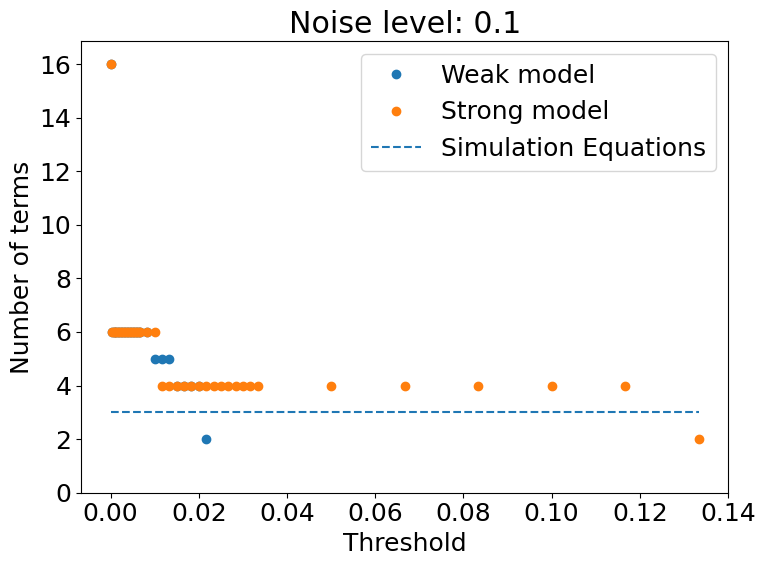

In [104]:
ys.plot_complexities(thresholds, complexities, noise_level=noise_level)

Noticing as these models are coming out that there is a long series of the exact same models between 0.05 and 0.18 in the weak case, with a few steps happening for the strong models. 
It might be interesting to look into an optimal threshold step size that would minimize SINDy discovering the same model over and over again.

In [ ]:
x_train = [sim.x for sim in sims010] # if sim.x.shape[0] == 5000]
t_train = sims010[0].t
weak_lib, strong_lib = generate_libraries(t_train)
opt = ps.STLSQ(threshold=0.5)
strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
strong_model.fit(x_train, t=t_train, multiple_trajectories=True)
strong_model.print(precision=5)

In [ ]:
opt = ps.STLSQ(threshold=0.2)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)

The weak form of SINDy discovers the correct underlying model with a threshold of 0.2, while strong-form SINDy does not discover the correct model.

### `noise_level=0.20`

In [ ]:
noise_level=0.20

### `noise_level=0.50`

In [ ]:
noise_level=0.50

In [ ]:
# code for spot-checking weak models
x_train = [sim.x for sim in sims050]
t_train = sims050[0].t

weak_lib, strong_lib = generate_libraries(t_train)
opt = ps.STLSQ(threshold=0.0001)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)